In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
hm450_hg19=pd.read_csv('../data/hm450.hg19.manifest.bed', sep='\t', header=None)
hm450_hg19

,0,1,2,3,4
0,chr1,15864,15866,-,cg13869341
1,chr1,18826,18828,-,cg14008030
2,chr1,29406,29408,-,cg12045430
3,chr1,29424,29426,-,cg20826792
4,chr1,29434,29436,-,cg00381604
...,...,...,...,...,...
485572,chrM,6761,6763,-,cg05001044
485573,chrM,6797,6799,+,cg03344490
485574,chrM,7196,7198,-,cg18024856
485575,chrM,9054,9056,+,cg03348902


In [4]:
(hm450_hg19[2] - hm450_hg19[1] == 1).values.sum()

3156

In [5]:
marker_to_chr_pos_tuple = dict(zip(hm450_hg19[4], zip(hm450_hg19[0], hm450_hg19[2] - 1)))

In [6]:
horvath_coef = pd.read_csv("../data/gb-2013-14-10-r115-S3.csv")
markers = horvath_coef["CpGmarker"]
coefs = horvath_coef["CoefficientTraining"]

In [7]:
horvath_chrs = markers.apply(marker_to_chr_pos_tuple.get)

In [8]:
data = pd.read_csv("../data/zeroes_imputed_cytosines.tsv", sep='\t')

In [9]:
chromosome, position = np.transpose([name.split(".") for name in data.values[:, 0]])
position = position.astype(int)

def compare_chr(chr1, p1, chr2, p2):
    return chr1 < chr2 or (chr1 == chr2 and p1 < p2)

def binary_search(c, p):
    left = 0
    right = len(chromosome)
    while right - left > 1:
        mid = (right + left) // 2
        if compare_chr(c, p, chromosome[mid], position[mid]):
            right = mid
        else:
            left = mid
    return left

In [10]:
horvath_ind = horvath_chrs.apply(lambda tup: binary_search(*tup))

In [11]:
raw_data = pd.read_csv("../data/filtered_cytosines_freq.tsv", sep='\t')

In [12]:
abs_values = np.isnan(raw_data.values[horvath_ind][:, 1:].astype(np.float64)).sum(axis=0)

In [13]:
rel_values  = (abs_values * 100) / len(raw_data.values[horvath_ind][:, 1:])

In [14]:
abs_values 

array([ 0,  4,  4,  2,  2,  1,  1,  4,  3,  3, 10,  1,  0,  1,  2,  2,  1,
        2,  1,  1,  0,  3,  1,  4,  2,  4,  2,  3,  1,  1,  0,  1,  3,  3,
        1,  1,  3,  2,  1,  0])

<BarContainer object of 40 artists>

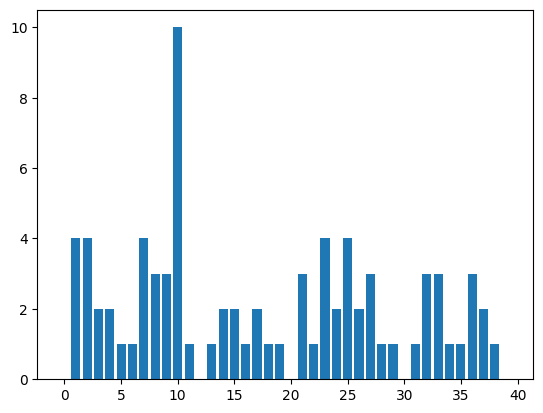

In [15]:
plt.bar(range(len(abs_values)), abs_values)

In [16]:
out = (data.values[horvath_ind][:, 1:] / 100).astype(np.float64).transpose().dot(coefs.astype(np.float64)) + 0.695507258

In [17]:
def F_inv(x):
    if x < 0:
        return 21 * np.exp(x) - 1
    else:
        return 21 * x + 20

In [18]:
predicted_age = np.vectorize(F_inv)(out)

In [19]:
real_age = pd.read_csv("../data/RRBS.phase1_yo_datasets.Monocyte.tsv", sep='\t')
real_age["Donor Age"] - predicted_age

0    -62.869674
1    -56.598380
2     -8.819683
3    -55.855088
4    -37.464169
5    -44.823178
6    -52.385561
7    -75.620244
8    -26.254121
9    -65.290252
10   -76.515772
11   -48.329550
12   -56.245883
13   -52.881872
14   -49.972979
15   -30.745161
16   -37.475532
17   -49.199554
18   -28.615820
19   -54.323259
20   -12.491321
21    47.222650
22    -0.639612
23    -7.471761
24   -15.933886
25   -10.343089
26    -6.215953
27   -10.267062
28    -3.566212
29    -0.044455
30    -8.606675
31    -5.898489
32    -6.923288
33     9.058443
34    -5.304665
35     0.170783
36   -19.023895
37     5.607288
38   -16.730234
39   -10.446635
Name: Donor Age, dtype: float64

Text(0, 0.5, 'real')

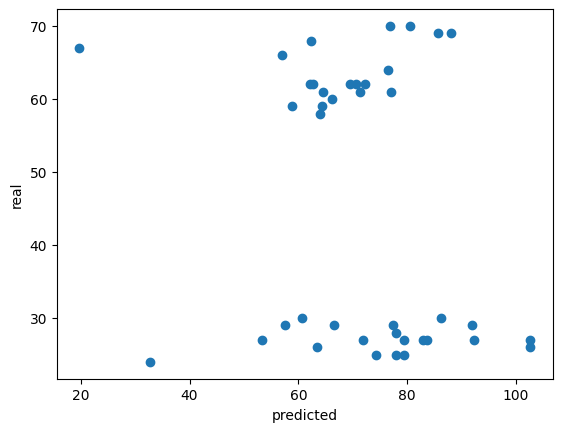

In [20]:
plt.scatter(predicted_age.astype(np.float64), real_age["Donor Age"].astype(np.float64))
plt.xlabel('predicted')
plt.ylabel('real')

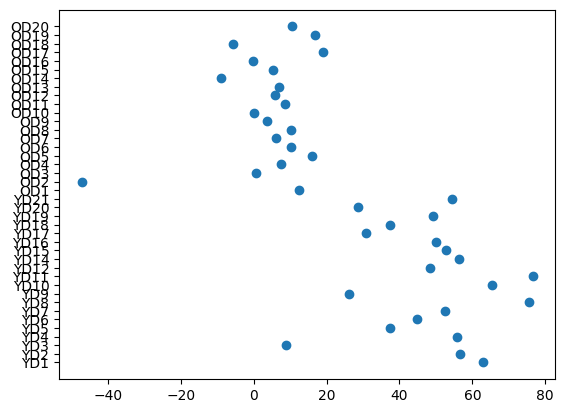

In [21]:
plt.scatter(predicted_age.astype(np.float64) - real_age["Donor Age"].astype(np.float64), real_age["Donor ID"])